## Notebook is still under construction
### Dataset Link-
https://www.kaggle.com/datasets/sumanthvrao/daily-climate-time-series-data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
train = pd.read_csv("DailyDelhiClimateTrain.csv", index_col="date", parse_dates=True)
train.index.freq = 'D'

In [3]:
test = pd.read_csv("DailyDelhiClimateTest.csv", index_col="date", parse_dates=True)
test.index.freq = 'D'

In [4]:
train.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2013-01-01,10.000000,84.500000,0.000000,1015.666667
2013-01-02,7.400000,92.000000,2.980000,1017.800000
2013-01-03,7.166667,87.000000,4.633333,1018.666667
2013-01-04,8.666667,71.333333,1.233333,1017.166667
2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [5]:
train.dtypes

meantemp        float64
humidity        float64
wind_speed      float64
meanpressure    float64
dtype: object

<AxesSubplot:xlabel='date'>

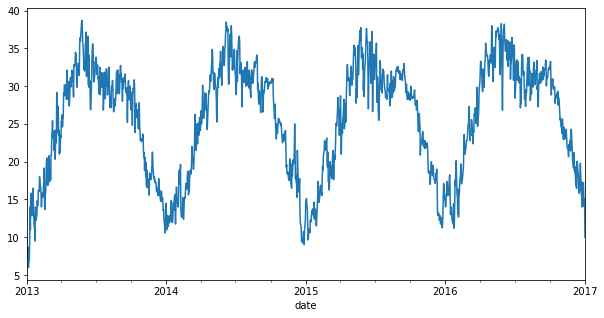

In [6]:
train['meantemp'].plot(figsize=(10,5))

In [7]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import acovf, acf, pacf, pacf_yw, pacf_ols
from pandas.plotting import lag_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

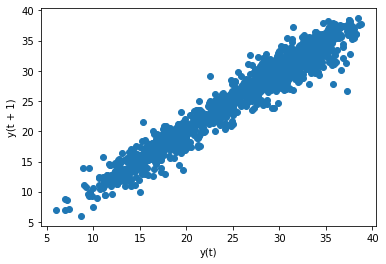

In [8]:
lag_plot(train['meantemp'])

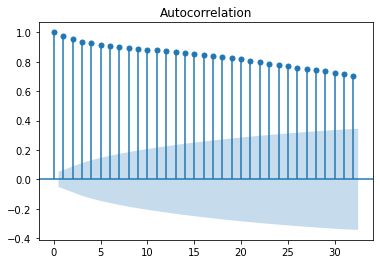

In [9]:
plot_acf(train['meantemp']);
#There is clear indication of the seasonality in the data

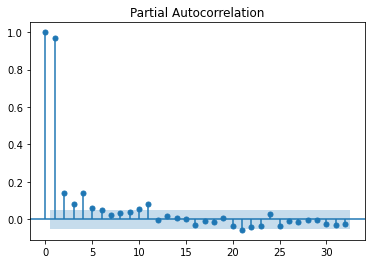

In [10]:
plot_pacf(train['meantemp']);

In [11]:
from statsmodels.tsa.stattools import adfuller

In [13]:
# we will check for the stationarity of the series
# we will make a function so that interpretation of the test will be a little easy

def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out[f'critical value ({key})']=val
        
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [14]:
adf_test(train['meantemp'])     

Augmented Dickey-Fuller Test: 
ADF test statistic        -2.021069
p-value                    0.277412
# lags used               10.000000
# observations          1451.000000
critical value (1%)       -3.434865
critical value (5%)       -2.863534
critical value (10%)      -2.567832
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary


In [20]:
train.tail()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2016-12-28,17.217391,68.043478,3.547826,1015.565217
2016-12-29,15.238095,87.857143,6.000000,1016.904762
2016-12-30,14.095238,89.666667,6.266667,1017.904762
2016-12-31,15.052632,87.000000,7.325000,1016.100000
2017-01-01,10.000000,100.000000,0.000000,1016.000000


In [21]:
test.head()

,meantemp,humidity,wind_speed,meanpressure
date,,,,
2017-01-01,15.913043,85.869565,2.743478,59.000000
2017-01-02,18.500000,77.222222,2.894444,1018.277778
2017-01-03,17.111111,81.888889,4.016667,1018.333333
2017-01-04,18.700000,70.050000,4.545000,1015.700000
2017-01-05,18.388889,74.944444,3.300000,1014.333333


In [23]:
len(test)

114

<AxesSubplot:xlabel='date'>

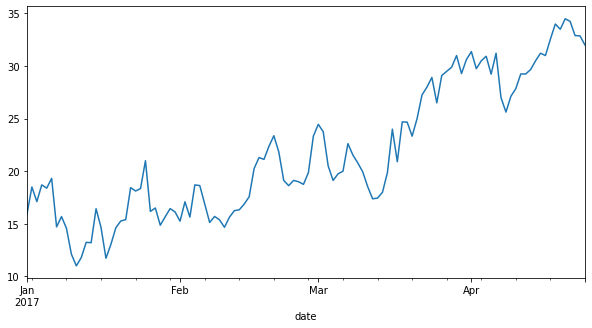

In [25]:
test['meantemp'].plot(figsize=(10,5))

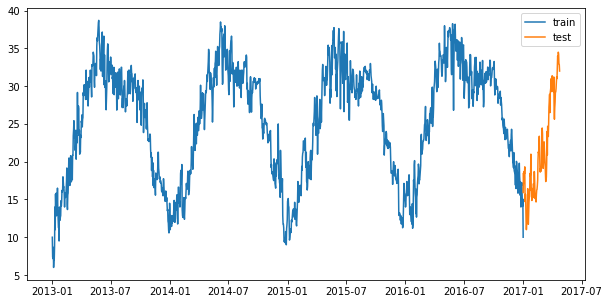

In [27]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(train.index, train['meantemp'], label = 'train')
ax.plot(test.index,test['meantemp'],label='test')
ax.legend();

In [32]:
from statsmodels.tsa.arima.model import ARIMA

In [36]:
arima = ARIMA(train['meantemp'], order=(1,0,0))

In [37]:
arima_result = arima.fit()

In [38]:
pred_ar1 = arima_result.predict(start = train.index[0], end = train.index[-1])

c:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:132: FutureWarning: The 'freq' argument in Timestamp is deprecated and will be removed in a future version.
  date_key = Timestamp(key, freq=base_index.freq)


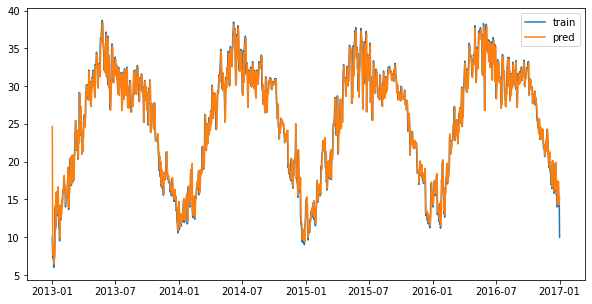

In [39]:
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(train.index, train['meantemp'], label = 'train')
ax.plot(train.index,pred_ar1,label='pred')
ax.legend();